# Transfer Learning

## Setup

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

#drive.mount('/content/drive')

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)
DATASET_URI= path + "/raw-img"
print("Path to dataset files:", DATASET_URI)

Resuming download from 416284672 bytes (197802630 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/alessiocorrado99/animals10?dataset_version_number=2 (416284672/614087302) bytes left.


100%|██████████| 586M/586M [00:09<00:00, 21.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2
Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img


## Data preprocessing

In [6]:
import keras
import matplotlib.pyplot as plt
import random

random.seed(10)
batch_size = 32 # Batch size increase to 64
img_height = 180
img_width = 180
seed = random.randint(1, 200)

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [10]:
class_names = np.array(train_ds.class_names)

In [7]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


## Load pre trained VGG16 model

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False  # Freeze the base model layers

Add custom classification layers

In [11]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


Compile the model

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Train the model

In [14]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    batch_size=batch_size,
    callbacks=[es]

)

NameError: name 'EarlyStopping' is not defined

In [85]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


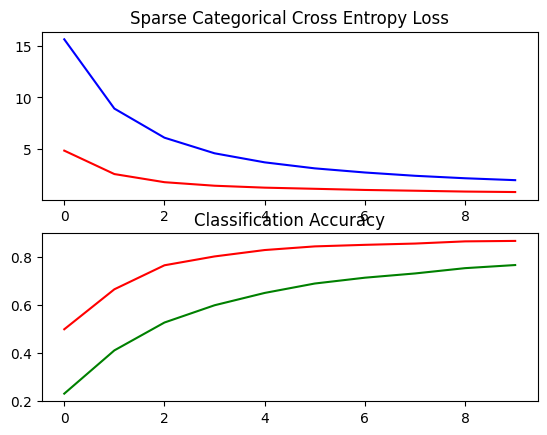

In [87]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')
plt.show()

Evaluate

In [82]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8690 - loss: 0.7502
Test Accuracy: 0.8681696653366089


## Fine tunning

Unfreeze some layers from model base

In [ ]:
base_model.trainable = True

freeze everything but the last 4

In [88]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [89]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # més petit!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [90]:
history_fine = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es]
)

Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.7722 - loss: 1.9211 - val_accuracy: 0.8728 - val_loss: 0.7710
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.7774 - loss: 1.8041 - val_accuracy: 0.8754 - val_loss: 0.7609
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.7754 - loss: 1.8813 - val_accuracy: 0.8731 - val_loss: 0.7531
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.7766 - loss: 1.8519 - val_accuracy: 0.8747 - val_loss: 0.7454
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.7772 - loss: 1.7922 - val_accuracy: 0.8754 - val_loss: 0.7404
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.7793 - loss: 1.7884 - val_accuracy: 0.8762 - val_loss: 0.7356
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.7848 - loss: 1.7586 - val_accuracy: 0.8758 - val_loss: 0.7305
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.7777 - loss: 1

Evaluate

In [91]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8783 - loss: 0.6841
Test accuracy: 0.8766


In [93]:


for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)

    for i in range(10):
        print(f"Real: {class_names[labels[i]]}, Predicted: {class_names[predicted_classes[i]]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Real: gatto, Predicted: gatto
Real: ragno, Predicted: ragno
Real: gallina, Predicted: cane
Real: gatto, Predicted: gatto
Real: gallina, Predicted: gallina
Real: cavallo, Predicted: cavallo
Real: cavallo, Predicted: cavallo
Real: gallina, Predicted: gallina
Real: cane, Predicted: cane
Real: gatto, Predicted: gatto


In [1]:


from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/CNN_Image_classification/m1_Mo_learning_transfer.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'model' is not defined

--------------------------------------------------------------------------